In [1]:
conda install -c conda-forge shap


Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Natal\anaconda3

  added / updated specs:
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-3.0.13             |       h2bbff1b_2         7.5 MB
    shap-0.42.1                |  py311hf62ec03_0         753 KB
    slicer-0.0.7               |     pyhd3eb1b0_0          18 KB
    ------------------------------------------------------------
                                           Total:         8.2 MB

The following NEW packages will be INSTALLED:

  shap               pkgs/main/win-64::shap-0.42.1-py311hf62ec03_0 
  slicer             pkgs/main/noarch::slicer-0.0.7-pyhd3eb1b0_0 

The following packages will be UPDATED:

  openssl                                 3.0.13-h2bbff1b_1 --> 3.0.13-h2bbff1b_2 




slicer-0.0.7         | 18 KB    



==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.5.0




In [384]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_validate, GridSearchCV, train_test_split, cross_val_score


import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

df_normal_quality = pd.read_csv('df_normal_quality.csv', index_col=0)
y = df_normal_quality.SalePrice
X = df_normal_quality.drop(['SalePrice', 'PID'], axis =1).copy()

In [387]:
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)
#categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", drop='first')
categorical_preprocessor =  OrdinalEncoder(handle_unknown="use_encoded_value", 
                                          unknown_value= -1)


numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("encoder", categorical_preprocessor, categorical_columns),
    ]
)

# xgb =  XGBRegressor(max_depth = 2, learning_rate = 0.03948737640519406,
#                    subsample = 0.3203617673528298, colsample_bytree =0.9678010901635519,
#                    min_child_weight = 2)

xgb =  XGBRegressor(n_estimators = 1000, max_depth = 2, learning_rate = 0.03948737640519406,
                    subsample = 0.3203617673528298, colsample_bytree =0.9678010901635519,
                    min_child_weight = 2)

xgb_pipe = Pipeline(steps=[("Preprocess", preprocessor), ("XGB", xgb)])

#xgb_regr = TransformedTargetRegressor(regressor= xgb_pipe,
                                             #    func=np.log, inverse_func=np.exp)

# param_grid = {
#     "regressor__XGB__max_depth": [3],
#     "regressor__XGB__learning_rate": [0.03948737640519406],
#     "regressor__XGB__subsample": [0.3203617673528298],
#     "regressor__XGB__colsample_bytree": [0.9678010901635519],
#     "regressor__XGB__n_estimators": [1000],
#     "regressor__XGB__min_child_weight": [2]
# }

param_grid = {
    "XGB__max_depth": [3],
    "XGB__learning_rate": [0.03948737640519406],
    "XGB__subsample": [0.3203617673528298],
    "XGB__colsample_bytree": [0.9678010901635519],
    "XGB__n_estimators": [1000],
    "XGB__min_child_weight": [2]
}

xgb_search = GridSearchCV(xgb_pipe, param_grid, n_jobs=2, cv = kf)

In [225]:
xgb_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('Preprocess',
                                        ColumnTransformer(transformers=[('standard_scaler',
                                                                         StandardScaler(),
                                                                         ['GrLivArea',
                                                                          'MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'Alley',
                                                                          'LotShape',
                                                                          'LandContour',
                                                                          'Utilities',
                                                                          'LandSlope',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'Ext...
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=1000,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             n_jobs=2,
             param_grid={'XGB__colsample_bytree': [0.9678010901635519],
                         'XGB__learning_rate': [0.03948737640519406],
                         'XGB__max_depth': [3], 'XGB__min_child_weight': [2],
                         'XGB__n_estimators': [1000],
                         'XGB__subsample': [0.3203617673528298]})

In [226]:
print(xgb_search.best_score_)
print(xgb_search.best_params_)

0.95184668642212
{'XGB__colsample_bytree': 0.9678010901635519, 'XGB__learning_rate': 0.03948737640519406, 'XGB__max_depth': 3, 'XGB__min_child_weight': 2, 'XGB__n_estimators': 1000, 'XGB__subsample': 0.3203617673528298}


In [388]:
X_scale = preprocessor.fit_transform(X)
X_scale

array([[-1.31047612, -0.65723049, -0.27116347, ...,  4.        ,
         8.        ,  0.        ],
       [-0.8920751 ,  1.42372685, -0.86919287, ...,  4.        ,
         8.        ,  0.        ],
       [-0.99613338, -0.65723049, -0.34339947, ...,  4.        ,
         8.        ,  0.        ],
       ...,
       [ 1.17391542,  0.7300744 ,  0.29923692, ...,  4.        ,
         8.        ,  0.        ],
       [ 0.82705447,  0.03642196, -0.05467572, ...,  4.        ,
         8.        ,  0.        ],
       [ 0.97663825,  0.03642196,  0.24081543, ...,  4.        ,
         8.        ,  0.        ]])

In [185]:
xgb.fit(X_scale, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9678010901635519, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03948737640519406,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [186]:
xgb.predict(X_scale)

array([127632.48, 136876.7 , 122253.04, ..., 148305.64, 222114.31,
       222939.08], dtype=float32)

In [9]:
xgb_search.fit(X, y)
print(xgb_search.best_score_)
print(xgb_search.best_params_)

0.95184668642212
{'XGB__colsample_bytree': 0.9678010901635519, 'XGB__learning_rate': 0.03948737640519406, 'XGB__max_depth': 3, 'XGB__min_child_weight': 2, 'XGB__n_estimators': 1000, 'XGB__subsample': 0.3203617673528298}


In [58]:
numerical_columns_selector(X)

['GrLivArea',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolQC',
 'MoSold',
 'YrSold',
 'Bathrooms']

In [35]:
predictions

array([125011.41 , 134832.44 , 120605.305, ..., 147615.33 , 224246.8  ,
       213646.95 ], dtype=float32)

In [67]:
categorical_columns_selector(X)

['MSZoning',
 'Street',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'Electrical',
 'GarageType',
 'GarageYN',
 'PoolYN',
 'Fence',
 'SaleType',
 'SaleCondition']

In [69]:
original_names = numerical_columns_selector(X) + categorical_columns_selector(X)

In [89]:
X.shape

(2333, 78)

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size=.75, random_state= 150)

X_train_scale =preprocessor.fit_transform(X_train)

X_test_scale = preprocessor.fit_transform(X_test)

xgb.fit(X_train_scale, y_train)

xgb.score(X_test_scale, y_test)

0.9277056795528565

In [219]:
X_train = X_train.reset_index(drop = True)

In [220]:
X_train

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,3SsnPorch,ScreenPorch,PoolYN,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,Bathrooms
0,1216,120,RM,32.000000,4500,Pave,0.0,1,4,4,...,0,0,no,0.0,NO,5,2006,WD,Normal,3.0
1,1442,20,RL,114.000000,10357,Pave,0.0,2,4,4,...,0,0,no,0.0,NO,5,2007,WD,Normal,3.0
2,1524,20,RL,82.000000,20270,Pave,0.0,2,4,4,...,0,0,no,0.0,NO,4,2008,WD,Normal,3.0
3,1360,80,RL,60.000000,7134,Pave,0.0,1,3,4,...,0,0,no,0.0,MnPrv,2,2007,WD,Normal,1.0
4,924,50,RL,60.000000,8064,Pave,0.0,1,4,4,...,0,0,no,0.0,MnPrv,7,2007,WD,Normal,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744,1742,120,RL,51.965755,6563,Pave,0.0,2,1,4,...,0,0,no,0.0,NO,12,2006,WD,Normal,3.0
1745,912,20,RL,61.689045,7791,Pave,0.0,2,4,4,...,0,0,no,0.0,GdWo,10,2009,WD,Normal,2.0
1746,1086,20,RL,85.000000,10200,Pave,0.0,1,4,4,...,0,0,no,0.0,GdWo,5,2010,WD,Normal,2.0
1747,2046,20,RL,105.000000,15431,Pave,0.0,1,4,4,...,0,175,no,0.0,NO,8,2007,WD,Normal,3.5


In [231]:
X_train.loc[X_train.OverallQual < 30].OverallQual

3       25
4       25
5       25
13      25
14      25
        ..
1740    25
1741    25
1743    25
1745    25
1746    25
Name: OverallQual, Length: 678, dtype: int64

In [227]:
scores = cross_val_score(xgb, X_scale, y, cv = kf, error_score='raise')
scores.mean()

0.9479550259985275

In [192]:
xgb.fit(X_train, y_train)

predictions = xgb.predict(X_test)

explainer = shap.Explainer(xgb, feature_names= original_names)
sv = explainer(X_train)

exp = Explanation(sv, sv.base_values, X_train, feature_names= original_names)
#exp = Explanation(sv[])
#waterfall_plot(sv)

In [327]:
sv

.values =
array([[-1.0703766e+04, -9.0073907e+02, -2.0120889e+02, ...,
        -8.0226021e+00,  0.0000000e+00,  0.0000000e+00],
       [-7.5401772e+03, -2.0268549e+02,  4.5455643e+02, ...,
         1.1342373e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.7755719e+03, -3.1565930e+02,  1.5187959e+03, ...,
        -8.0226021e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-1.2554402e+04, -1.1571822e+02,  9.7934119e+02, ...,
         2.2476649e+02,  0.0000000e+00,  0.0000000e+00],
       [ 2.5280166e+04, -3.9410999e+02,  7.8391826e+03, ...,
         1.1342373e+00,  0.0000000e+00,  0.0000000e+00],
       [ 8.0693589e+03, -2.6042987e+02,  1.9231541e+02, ...,
        -8.0226021e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

.base_values =
array([172908.8, 172908.8, 172908.8, ..., 172908.8, 172908.8, 172908.8],
      dtype=float32)

.data =
array([[-0.53323334,  1.44007623, -1.32530069, ...,  4.        ,
         8.        ,  0.        ],
       [-0.03616525, -0.8859092 ,  

In [256]:
sv.values

array([[-1.0703766e+04, -9.0073907e+02, -2.0120889e+02, ...,
        -8.0226021e+00,  0.0000000e+00,  0.0000000e+00],
       [-7.5401772e+03, -2.0268549e+02,  4.5455643e+02, ...,
         1.1342373e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.7755719e+03, -3.1565930e+02,  1.5187959e+03, ...,
        -8.0226021e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-1.2554402e+04, -1.1571822e+02,  9.7934119e+02, ...,
         2.2476649e+02,  0.0000000e+00,  0.0000000e+00],
       [ 2.5280166e+04, -3.9410999e+02,  7.8391826e+03, ...,
         1.1342373e+00,  0.0000000e+00,  0.0000000e+00],
       [ 8.0693589e+03, -2.6042987e+02,  1.9231541e+02, ...,
        -8.0226021e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [482]:
sv.data

array([[-0.53323334,  1.44007623, -1.32530069, ...,  4.        ,
         8.        ,  0.        ],
       [-0.03616525, -0.8859092 ,  1.41491391, ...,  4.        ,
         8.        ,  0.        ],
       [ 0.14418689, -0.8859092 ,  0.34556187, ...,  4.        ,
         8.        ,  0.        ],
       ...,
       [-0.81915746, -0.8859092 ,  0.44581362, ...,  1.        ,
         8.        ,  0.        ],
       [ 1.29228222, -0.8859092 ,  1.11415865, ...,  4.        ,
         8.        ,  0.        ],
       [ 0.73363047, -0.8859092 ,  0.01138936, ...,  4.        ,
         8.        ,  0.        ]])

In [255]:
sv.base_values

array([172908.8, 172908.8, 172908.8, ..., 172908.8, 172908.8, 172908.8],
      dtype=float32)

In [253]:
type(exp)

shap._explanation.Explanation

In [250]:
X_train.loc[X_train.OverallQual == 9].OverallQual

37      9
40      9
146     9
147     9
179     9
216     9
268     9
321     9
345     9
381     9
408     9
450     9
479     9
713     9
873     9
992     9
1355    9
1401    9
1406    9
1428    9
1454    9
1498    9
1640    9
1673    9
Name: OverallQual, dtype: int64

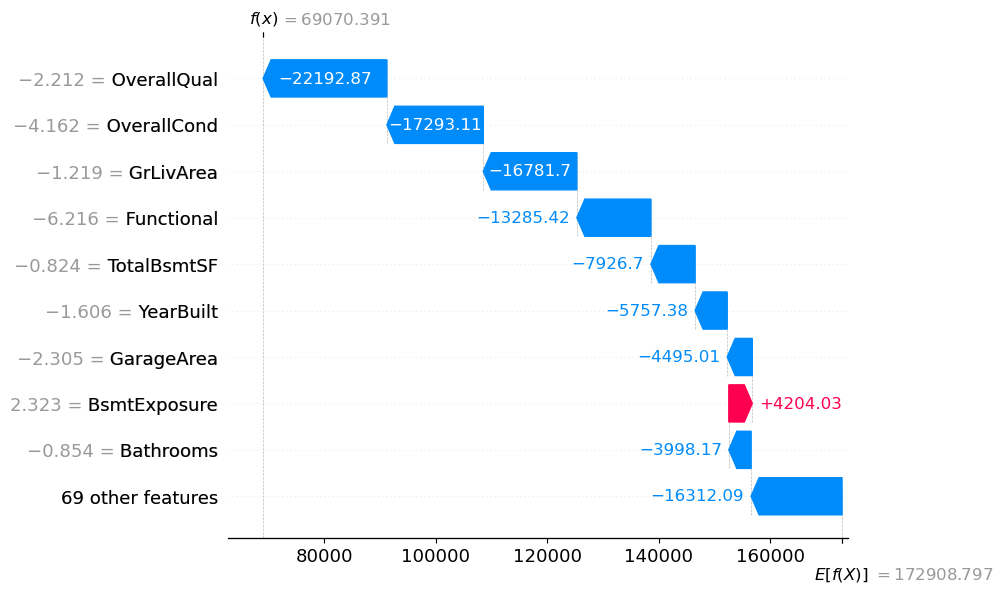

In [251]:
# quality of 1
shap.waterfall_plot(exp[244])

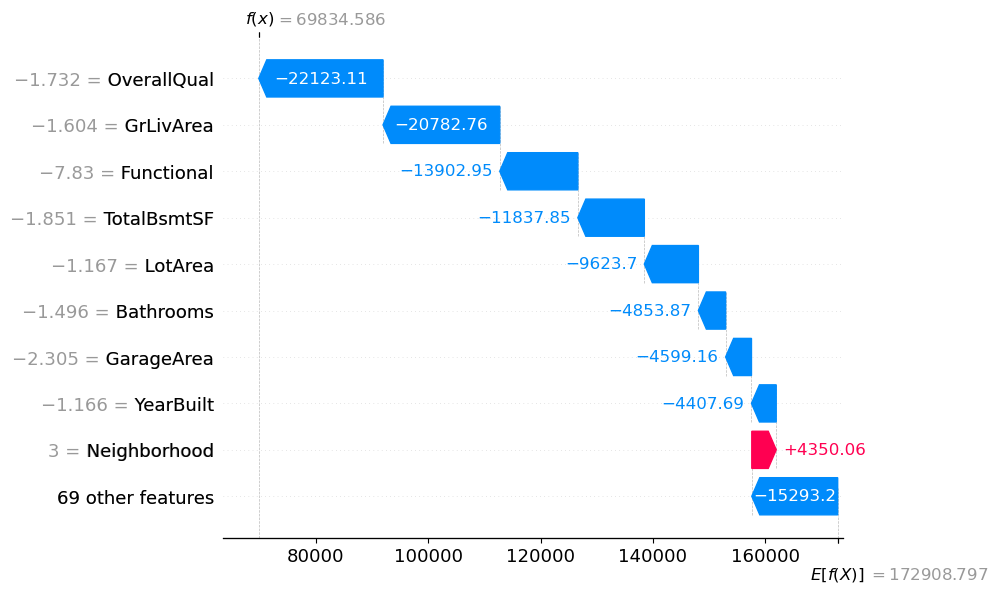

In [252]:
# quality of 3
shap.waterfall_plot(exp[1454])

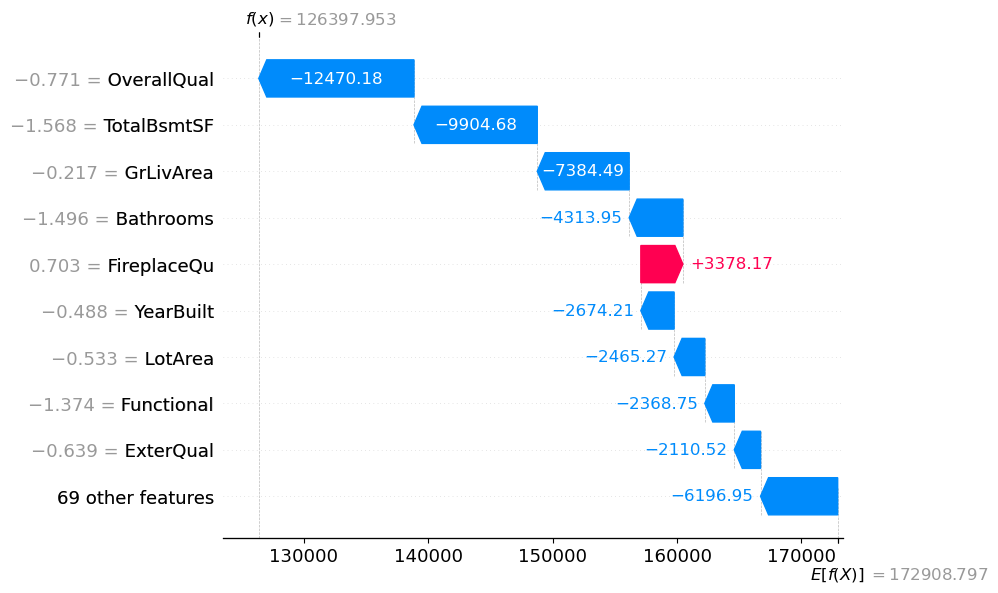

In [246]:
# quality of 5
shap.waterfall_plot(exp[3])

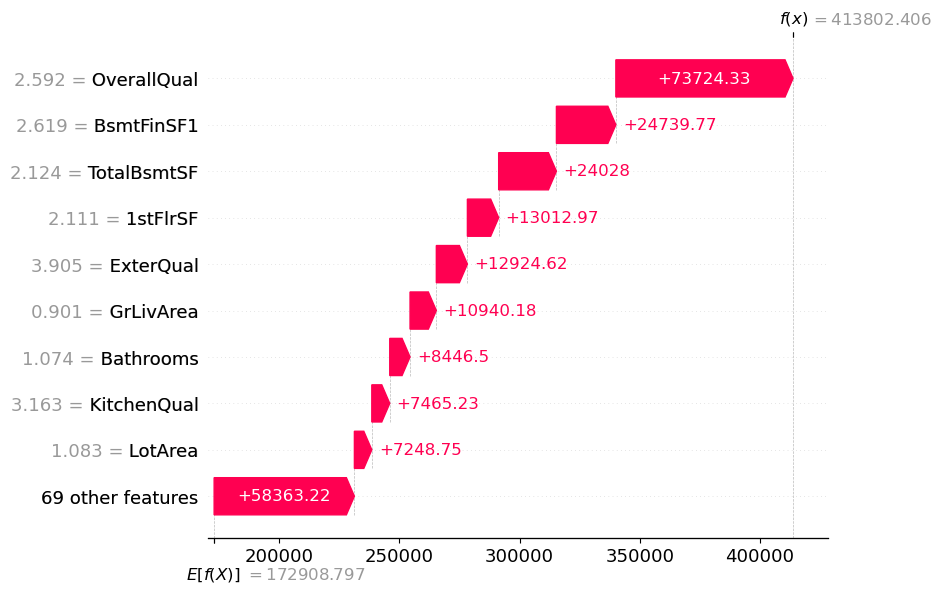

In [243]:
# quality of 9
shap.waterfall_plot(exp[9])

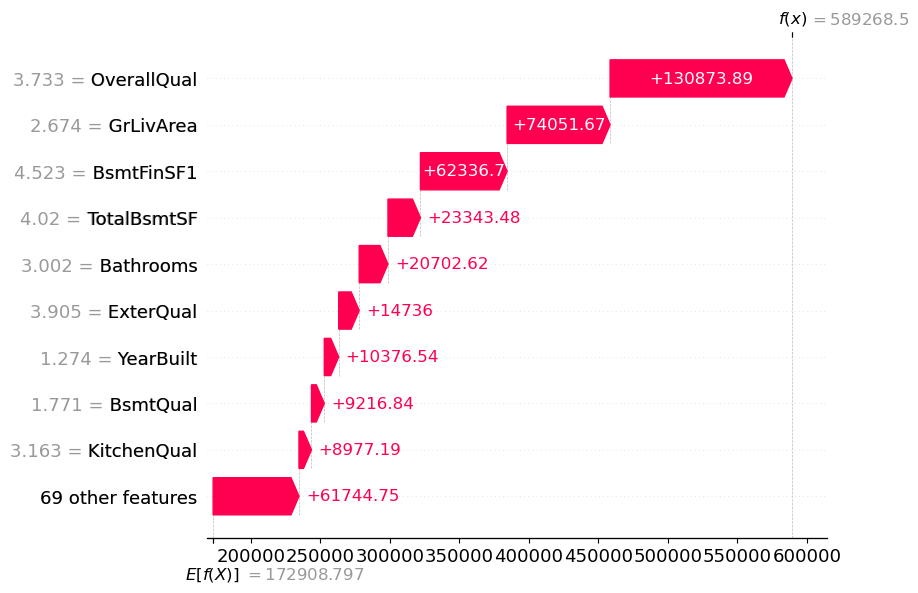

In [244]:
# Quality of 10
shap.waterfall_plot(exp[15])

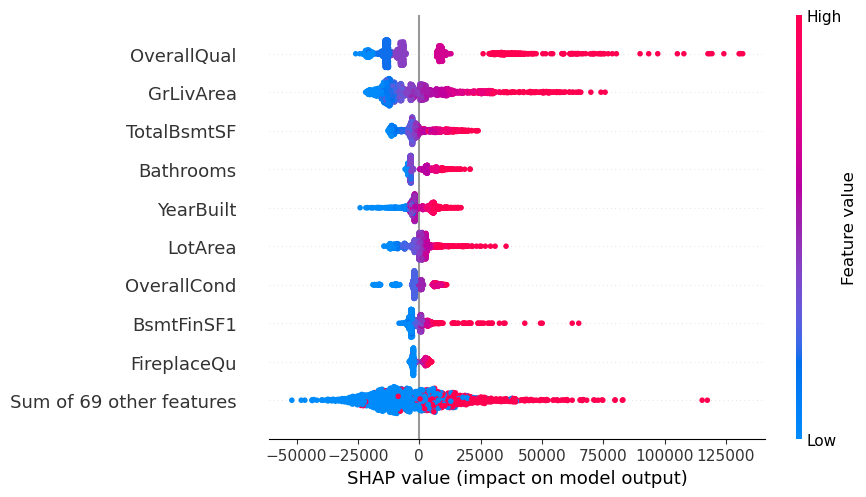

In [257]:
shap.plots.beeswarm(exp)

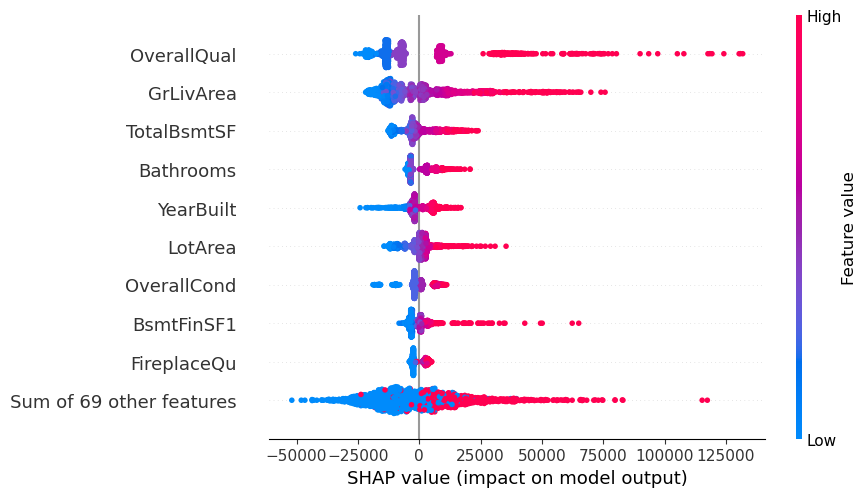

In [258]:
shap.plots.beeswarm(sv)

In [414]:
df_normal_quality = pd.read_csv('df_normal_quality.csv', index_col=0)
y = df_normal_quality.SalePrice
X = df_normal_quality.drop(['SalePrice', 'PID'], axis =1).copy()

In [415]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

numerical_preprocessor = RobustScaler()


preprocessor = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)

lasso = Lasso(alpha= 0.0003061900989342117)

lasso_pipe = Pipeline(steps=[("Preprocess", preprocessor), ("Lasso", lasso)])

lasso_regr = TransformedTargetRegressor(regressor= lasso_pipe,
                                                func=np.log, inverse_func=np.exp)

In [416]:
scores = cross_val_score(lasso_regr, X, y, cv = kf)
scores.mean()

0.9508125946535184

In [5]:
lasso_pipe.fit(X,y)

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('standard_scaler',
                                                  RobustScaler(),
                                                  ['GrLivArea', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LandSlope', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1', 'Bs...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MSZoning', 'Street',
                                                   'LotConfig', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'Foundation',
                                                   'Heating', 'CentralAir',
                                                   'Electrical', 'GarageType',
                                                   'GarageYN', 'PoolYN',
                                                   'Fence', 'SaleType',
                                                   'SaleCondition'])])),
                ('Lasso', Lasso(alpha=0.0003061900989342117))])

In [6]:
explainer = shap.Explainer(lasso_pipe['Lasso'])
data_transformation = lasso_pipe['Preprocess'].transform(X)
shap_values = explainer(data_transformation)

shap.plots.waterfall(shap_values[0])

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: Lasso(alpha=0.0003061900989342117)

In [22]:
lasso_scores = cross_val_score(lasso_regr, X, y, cv = kf, error_score='raise')
lasso_scores.mean()

0.9508125946535184

In [ ]:
e

In [23]:
ridge = Ridge(alpha=19.535539796579627)

ridge_pipe = Pipeline(steps=[("Preprocess", preprocessor), ("Ridge", ridge)])

ridge_regr = TransformedTargetRegressor(regressor= ridge_pipe,
                                                func=np.log, inverse_func=np.exp)


In [24]:
ridge_scores = cross_val_score(ridge_regr, X, y, cv = kf, error_score='raise')
ridge_scores.mean()

0.95003638254706

# Lasso with chatGBT

In [488]:
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")               

numerical_preprocessor = RobustScaler()


preprocessor = ColumnTransformer(
    [
        ("robust_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)

lasso = Lasso(alpha =  0.00030615490713200075)

lasso_pipe = Pipeline(steps=[("Preprocess", preprocessor), ("Lasso", lasso)])


lasso_regr = TransformedTargetRegressor(regressor= lasso_pipe,
                                            func=np.log, inverse_func=np.exp)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lasso_regr, X, y, cv = kf, error_score='raise')

scores.mean()

0.9508125912427354

In [410]:
lasso_pipe_2

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('robust_scaler',
                                                  RobustScaler(),
                                                  ['GrLivArea', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LandSlope', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1', 'Bsmt...
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'Foundation',
                                                   'Heating', 'CentralAir',
                                                   'Electrical', 'GarageType',
                                                   'GarageYN', 'PoolYN',
                                                   'Fence', 'SaleType',
                                                   'SaleCondition'])])),
                ('Regressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Lasso(alpha=0.00030615490713200075)))])

In [424]:
lasso_pipe_2 = Pipeline(steps=[("Preprocess", preprocessor), 
                             ("Regressor", TransformedTargetRegressor(regressor = Lasso(alpha = 0.00030615490713200075),
                                                                func =np.log, inverse_func=np.exp))])

scores = cross_val_score(lasso_pipe_2, X, y, cv = kf, error_score='raise')

scores.mean()

0.9508125912427354

In [427]:
lasso_pipe_2.

AttributeError: 'Pipeline' object has no attribute 'regressor_'

In [435]:
lasso_regressor = lasso_pipe_2.named_steps['Regressor'].regressor

explainer = shap.Explainer(lasso_regressor.predict, X)

shap_values = explainer.shap_values(X)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [441]:
lasso_pipe

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('robust_scaler',
                                                  RobustScaler(),
                                                  ['GrLivArea', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LandSlope', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1', 'Bsmt...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MSZoning', 'Street',
                                                   'LotConfig', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'Foundation',
                                                   'Heating', 'CentralAir',
                                                   'Electrical', 'GarageType',
                                                   'GarageYN', 'PoolYN',
                                                   'Fence', 'SaleType',
                                                   'SaleCondition'])])),
                ('Lasso', Lasso(alpha=0.00030615490713200075))])

In [ ]:
lasso_pipe.named_steps

In [489]:
lasso_pipe.fit(X, y)

# Create a SHAP explainer for the Lasso model

explainer = shap.Explainer(lasso_pipe.named_steps['Lasso'],
                          lasso_pipe.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values = explainer(lasso_pipe.named_steps['Preprocess'].transform(X))


In [490]:
lasso.fit(preprocessor.fit_transform(X), y)

explainer = shap.Explainer(lasso, preprocessor.fit_transform(X))

shap_values = explainer(preprocessor.fit_transform(X))

shap_values

.values =
array([[-4.72361883e+04,  2.89193716e+03,  9.16224384e+02, ...,
        -0.00000000e+00, -2.43664174e+00,  0.00000000e+00],
       [-3.01728800e+04, -6.25654594e+03,  2.36663848e+03, ...,
        -0.00000000e+00, -2.43664174e+00,  0.00000000e+00],
       [-3.44166044e+04,  2.89193716e+03,  1.09141997e+03, ...,
        -0.00000000e+00, -2.43664174e+00,  0.00000000e+00],
       ...,
       [ 5.40827302e+04, -3.20705157e+03, -4.67180441e+02, ...,
        -0.00000000e+00, -2.43664174e+00,  0.00000000e+00],
       [ 3.99369825e+04, -1.57557209e+02,  3.91171807e+02, ...,
        -0.00000000e+00, -2.43664174e+00,  0.00000000e+00],
       [ 4.60373362e+04, -1.57557209e+02, -3.25489495e+02, ...,
        -0.00000000e+00, -2.43664174e+00,  0.00000000e+00]])

.base_values =
array([167601.10881253, 167601.10881253, 167601.10881253, ...,
       167601.10881253, 167601.10881253, 167601.10881253])

.data =
array([[-0.91734198, -0.4       , -0.33139011, ...,  0.        ,
         1.        , 

In [263]:
# Get feature names after transformation
transformed_feature_names = lasso_regr.regressor_.named_steps['Preprocess'].get_feature_names_out()

In [288]:
# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df = pd.DataFrame(shap_values.values, columns=transformed_feature_names)
# this are the values of X after preprocessing 
X_transformed_df = pd.DataFrame(lasso_regr.regressor_.named_steps['Preprocess'].transform(X), columns=transformed_feature_names)


In [290]:
# Identify original categorical features' prefixes in transformed data
categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["one-hot-encoder__" + word for word in categorical_prefixes]
categorical_prefixes

['one-hot-encoder__MSZoning',
 'one-hot-encoder__Street',
 'one-hot-encoder__LotConfig',
 'one-hot-encoder__Neighborhood',
 'one-hot-encoder__Condition1',
 'one-hot-encoder__Condition2',
 'one-hot-encoder__BldgType',
 'one-hot-encoder__HouseStyle',
 'one-hot-encoder__RoofStyle',
 'one-hot-encoder__RoofMatl',
 'one-hot-encoder__Exterior1st',
 'one-hot-encoder__Exterior2nd',
 'one-hot-encoder__MasVnrType',
 'one-hot-encoder__Foundation',
 'one-hot-encoder__Heating',
 'one-hot-encoder__CentralAir',
 'one-hot-encoder__Electrical',
 'one-hot-encoder__GarageType',
 'one-hot-encoder__GarageYN',
 'one-hot-encoder__PoolYN',
 'one-hot-encoder__Fence',
 'one-hot-encoder__SaleType',
 'one-hot-encoder__SaleCondition']

In [291]:
# Aggregate SHAP values for each categorical feature
for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df[prefix] = shap_values_df[columns].mean(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df.drop(columns=columns, inplace=True)
    
    # Update the transformed data DataFrame similarly
    X_transformed_df[prefix] = X_transformed_df[columns].mean(axis=1)
    X_transformed_df.drop(columns=columns, inplace=True)

# Now shap_values_df contains SHAP values with aggregated categorical feature contributions

In [318]:
X_transformed_df

,robust_scaler__GrLivArea,robust_scaler__MSSubClass,robust_scaler__LotFrontage,robust_scaler__LotArea,robust_scaler__Alley,robust_scaler__LotShape,robust_scaler__LandContour,robust_scaler__Utilities,robust_scaler__LandSlope,robust_scaler__OverallQual,...,one-hot-encoder__Foundation,one-hot-encoder__Heating,one-hot-encoder__CentralAir,one-hot-encoder__Electrical,one-hot-encoder__GarageType,one-hot-encoder__GarageYN,one-hot-encoder__PoolYN,one-hot-encoder__Fence,one-hot-encoder__SaleType,one-hot-encoder__SaleCondition
0,-0.917342,-0.4,-0.331390,-0.355114,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0
1,-0.604538,1.4,-1.232740,-1.273687,0.0,0.0,0.0,0.0,0.0,-0.458333,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0
2,-0.682334,-0.4,-0.440264,-0.815029,0.0,0.0,0.0,0.0,0.0,-0.458333,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0
3,-0.620746,0.4,0.440264,-0.290777,0.0,0.0,0.0,0.0,0.0,-0.833333,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0
4,0.393841,0.2,0.000000,-0.226941,0.0,0.0,0.0,0.0,0.0,1.166667,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,-0.761750,-0.4,0.004661,-0.112842,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0
2329,0.504052,-0.6,1.687008,1.100025,0.0,1.0,0.0,0.0,0.0,-1.125000,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0
2330,0.940032,0.8,0.528317,-0.762252,0.0,0.0,-2.0,0.0,0.0,-0.458333,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0
2331,0.680713,0.2,-0.005100,-0.119879,0.0,0.0,0.0,0.0,0.0,0.541667,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0


In [472]:
X

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,3SsnPorch,ScreenPorch,PoolYN,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,Bathrooms
0,856,30,RL,62.472926,7890,Pave,0.0,1,4,4,...,0,166,no,0.0,NO,3,2010,WD,Normal,2.0
1,1049,120,RL,42.000000,4235,Pave,0.0,1,4,4,...,0,0,no,0.0,NO,2,2009,WD,Normal,3.0
2,1001,30,C (all),60.000000,6060,Pave,0.0,1,4,4,...,86,0,no,0.0,NO,11,2007,WD,Normal,1.0
3,1039,70,RL,80.000000,8146,Pave,0.0,1,4,4,...,0,111,no,0.0,NO,5,2009,WD,Normal,1.0
4,1665,60,RL,70.000000,8400,Pave,0.0,1,4,4,...,0,0,no,0.0,NO,11,2009,WD,Normal,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,952,30,RL,70.105866,8854,Pave,0.0,1,4,4,...,0,40,no,0.0,NO,5,2009,WD,Normal,1.0
2576,1733,20,RL,108.318076,13680,Pave,0.0,2,4,4,...,0,0,no,0.0,NO,6,2009,WD,Normal,2.0
2577,2002,90,RH,82.000000,6270,Pave,0.0,1,2,4,...,0,0,no,0.0,NO,8,2007,WD,Normal,2.0
2578,1842,60,RL,69.884162,8826,Pave,0.0,1,4,4,...,0,0,no,0.0,NO,7,2007,WD,Normal,3.5


In [323]:
X_new_order = list(numerical_columns) + list(categorical_columns)
X_new_order =X[X_new_order]
X_new_order

,GrLivArea,MSSubClass,LotFrontage,LotArea,Alley,LotShape,LandContour,Utilities,LandSlope,OverallQual,...,Foundation,Heating,CentralAir,Electrical,GarageType,GarageYN,PoolYN,Fence,SaleType,SaleCondition
0,856,30,62.472926,7890,0.0,1,4,4,3,36,...,CBlock,GasA,Y,SBrkr,Detchd,yes,no,NO,WD,Normal
1,1049,120,42.000000,4235,0.0,1,4,4,3,25,...,CBlock,GasA,Y,SBrkr,Attchd,yes,no,NO,WD,Normal
2,1001,30,60.000000,6060,0.0,1,4,4,3,25,...,BrkTil,GasA,Y,SBrkr,Detchd,yes,no,NO,WD,Normal
3,1039,70,80.000000,8146,0.0,1,4,4,3,16,...,BrkTil,GasA,Y,SBrkr,Detchd,yes,no,NO,WD,Normal
4,1665,60,70.000000,8400,0.0,1,4,4,3,64,...,PConc,GasA,Y,SBrkr,Attchd,yes,no,NO,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,952,30,70.105866,8854,0.0,1,4,4,3,36,...,BrkTil,Grav,N,FuseF,Detchd,yes,no,NO,WD,Normal
2576,1733,20,108.318076,13680,0.0,2,4,4,3,9,...,Slab,GasA,Y,FuseA,Attchd,yes,no,NO,WD,Normal
2577,2002,90,82.000000,6270,0.0,1,2,4,3,25,...,CBlock,GasA,N,FuseA,2Types,yes,no,NO,WD,Normal
2578,1842,60,69.884162,8826,0.0,1,4,4,3,49,...,PConc,GasA,Y,SBrkr,Attchd,yes,no,NO,WD,Normal


In [470]:
X_transformed_df

,robust_scaler__GrLivArea,robust_scaler__MSSubClass,robust_scaler__LotFrontage,robust_scaler__LotArea,robust_scaler__Alley,robust_scaler__LotShape,robust_scaler__LandContour,robust_scaler__Utilities,robust_scaler__LandSlope,robust_scaler__OverallQual,...,one-hot-encoder__Foundation,one-hot-encoder__Heating,one-hot-encoder__CentralAir,one-hot-encoder__Electrical,one-hot-encoder__GarageType,one-hot-encoder__GarageYN,one-hot-encoder__PoolYN,one-hot-encoder__Fence,one-hot-encoder__SaleType,one-hot-encoder__SaleCondition
0,-0.917342,-0.4,-0.331390,-0.355114,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0
1,-0.604538,1.4,-1.232740,-1.273687,0.0,0.0,0.0,0.0,0.0,-0.458333,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0
2,-0.682334,-0.4,-0.440264,-0.815029,0.0,0.0,0.0,0.0,0.0,-0.458333,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0
3,-0.620746,0.4,0.440264,-0.290777,0.0,0.0,0.0,0.0,0.0,-0.833333,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0
4,0.393841,0.2,0.000000,-0.226941,0.0,0.0,0.0,0.0,0.0,1.166667,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,-0.761750,-0.4,0.004661,-0.112842,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0
2329,0.504052,-0.6,1.687008,1.100025,0.0,1.0,0.0,0.0,0.0,-1.125000,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0
2330,0.940032,0.8,0.528317,-0.762252,0.0,0.0,-2.0,0.0,0.0,-0.458333,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0
2331,0.680713,0.2,-0.005100,-0.119879,0.0,0.0,0.0,0.0,0.0,0.541667,...,0.166667,0.166667,0.5,0.25,0.142857,0.5,0.5,0.2,0.111111,1.0


In [326]:
shap_values_df =shap_values_df.applymap(np.exp)
shap_values_df

,robust_scaler__GrLivArea,robust_scaler__MSSubClass,robust_scaler__LotFrontage,robust_scaler__LotArea,robust_scaler__Alley,robust_scaler__LotShape,robust_scaler__LandContour,robust_scaler__Utilities,robust_scaler__LandSlope,robust_scaler__OverallQual,...,one-hot-encoder__Foundation,one-hot-encoder__Heating,one-hot-encoder__CentralAir,one-hot-encoder__Electrical,one-hot-encoder__GarageType,one-hot-encoder__GarageYN,one-hot-encoder__PoolYN,one-hot-encoder__Fence,one-hot-encoder__SaleType,one-hot-encoder__SaleCondition
0,0.868811,1.0,1.003903,0.985316,0.999895,0.999555,0.999962,1.0,1.0,1.004229,...,0.998853,1.0,1.001344,1.0,0.999213,1.0,1.0,1.000066,1.0,1.0
1,0.914087,1.0,1.010112,0.964166,0.999895,0.999555,0.999962,1.0,1.0,0.953192,...,0.998853,1.0,1.001344,1.0,1.000503,1.0,1.0,1.000066,1.0,1.0
2,0.902611,1.0,1.004651,0.974669,0.999895,0.999555,0.999962,1.0,1.0,0.953192,...,0.997898,1.0,1.001344,1.0,0.999213,1.0,1.0,1.000066,1.0,1.0
3,0.911684,1.0,0.998617,0.986814,0.999895,0.999555,0.999962,1.0,1.0,0.913369,...,0.997898,1.0,1.001344,1.0,0.999213,1.0,1.0,1.000066,1.0,1.0
4,1.074988,1.0,1.001629,0.988303,0.999895,0.999555,0.999962,1.0,1.0,1.146816,...,1.001887,1.0,1.001344,1.0,1.000503,1.0,1.0,1.000066,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,0.891044,1.0,1.001598,0.990971,0.999895,0.999555,0.999962,1.0,1.0,1.004229,...,0.997898,1.0,0.982321,1.0,0.999213,1.0,1.0,1.000066,1.0,1.0
2329,1.094402,1.0,0.990136,1.019774,0.999895,1.000590,0.999962,1.0,1.0,0.883550,...,0.998853,1.0,1.001344,1.0,1.000503,1.0,1.0,1.000066,1.0,1.0
2330,1.174700,1.0,0.998016,0.975885,0.999895,0.999555,1.000723,1.0,1.0,0.953192,...,0.998853,1.0,0.982321,1.0,0.999213,1.0,1.0,1.000066,1.0,1.0
2331,1.126256,1.0,1.001664,0.990806,0.999895,0.999555,0.999962,1.0,1.0,1.068081,...,1.001887,1.0,1.001344,1.0,1.000503,1.0,1.0,1.000066,1.0,1.0


In [325]:
np.exp(-0.14063)

0.868810712198422

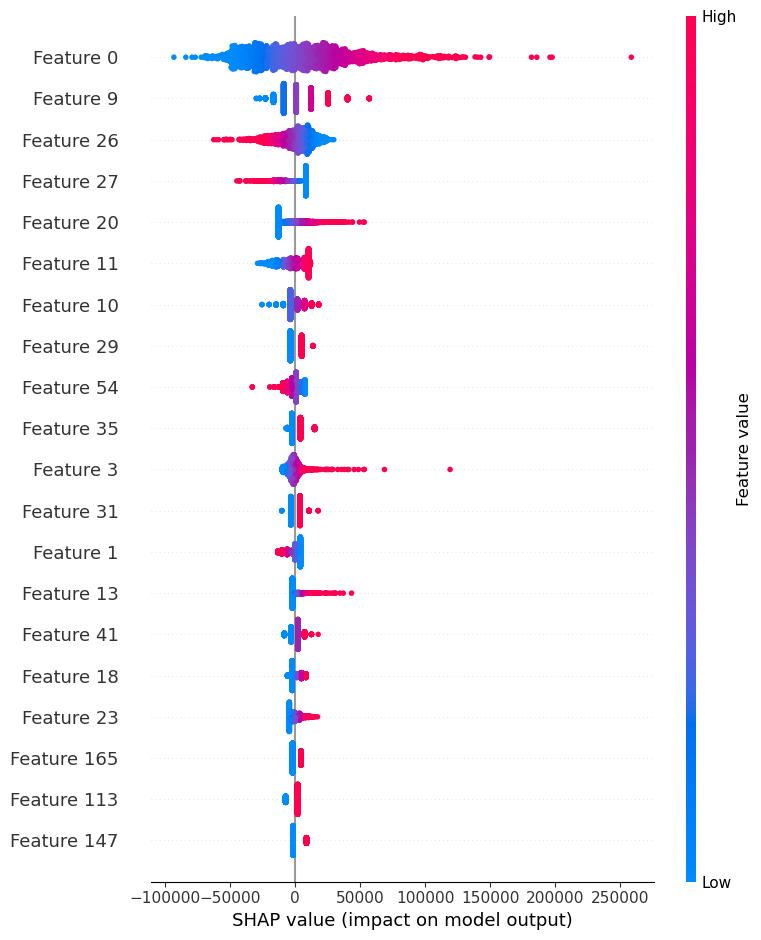

In [491]:
shap.summary_plot(shap_values)

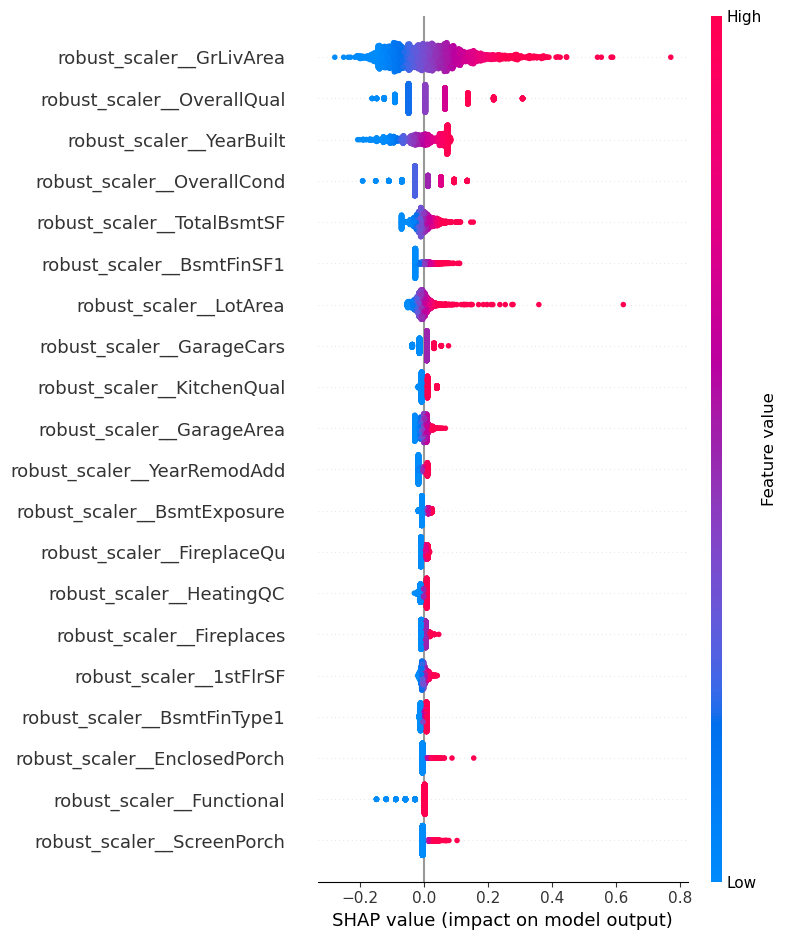

In [324]:
shap.initjs()
# shap.force_plot(explainer.expected_value, 
#                 shap_values_df.iloc[0].values, 
#                 X_transformed_df.iloc[0].values)

# Summary plot
shap.summary_plot(shap_values_df.values, 
                  X_new_order.values, feature_names=shap_values_df.columns)